# Framework

- Spreads 
    - Crack - (Gasoline - WTI) (RB - CL)
    - ~~Crush - (Soybeans - Soyoil) (ZS - ZL)~~
    - ~~Spark - (Gulf Coast LNG Export Futures - ERCOT SOUTH 345 KV HUB) (LNG - YUEF1)~~
    - ~~Frac - (Natural Gas - Heating Oil) (LNG - H0)~~

- Rollover Method
    - By Same Expiration Date

- Filters
    - Unfiltered
    - Threshold
    - Correlation
    - Volatility

- Models
    - Fair value model
        - Johansen Portfolio
        - TAR Model
    - [Multi Layer Perceptron](#mlp) 
    - [Long Short Term Memory Network](#rnn)
    - Higher-Order Neural Network
        - Single Layer
            - [Feature Expander](#flnn)
        - Multi layer
            - [Pi Sigma Neural Network](#pisigma)

- Ensemble
    - RegressorCommittee

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
from IPython.display import Image

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from arbitragelab.cointegration_approach.johansen import JohansenPortfolio
from arbitragelab.ml_approach.regressor_committee import RegressorCommittee
from arbitragelab.ml_approach.neural_networks import MultiLayerPerceptron, RecurrentNeuralNetwork, PiSigmaNeuralNetwork
from arbitragelab.util.spread_modeling_helper import SpreadModelingHelper

import warnings
warnings.filterwarnings('ignore')

In [4]:
wti_contract_df = pd.read_csv('./data/NonNegative_CL_forward_roll.csv').set_index('Dates')

rbob_contract_df = pd.read_csv('./data/NonNegative_nRB_forward_roll.csv').set_index('Dates')

working_df = pd.concat([wti_contract_df, rbob_contract_df], axis=1)
working_df.index = pd.to_datetime(working_df.index) 
working_df.columns = ['wti', 'gasoline']

working_df.dropna(inplace=True)
working_df

,wti,gasoline
Dates,,
2006-01-03,1.034404,1.026552
2006-01-04,1.038991,1.048563
2006-01-05,1.028670,1.044253
2006-01-06,1.051933,1.060632
2006-01-09,1.040301,1.033046
...,...,...
2019-12-25,0.431366,1.056159
2019-12-26,0.435390,1.072488
2019-12-27,0.435672,1.068574


In [5]:
johansen_portfolio = JohansenPortfolio()
johansen_portfolio.fit(working_df)
sprd = johansen_portfolio.construct_mean_reverting_portfolio(working_df).pct_change()

# Multi Layer Perceptron  <a class="anchor" id="mlp"></a>

0.4173550998692712


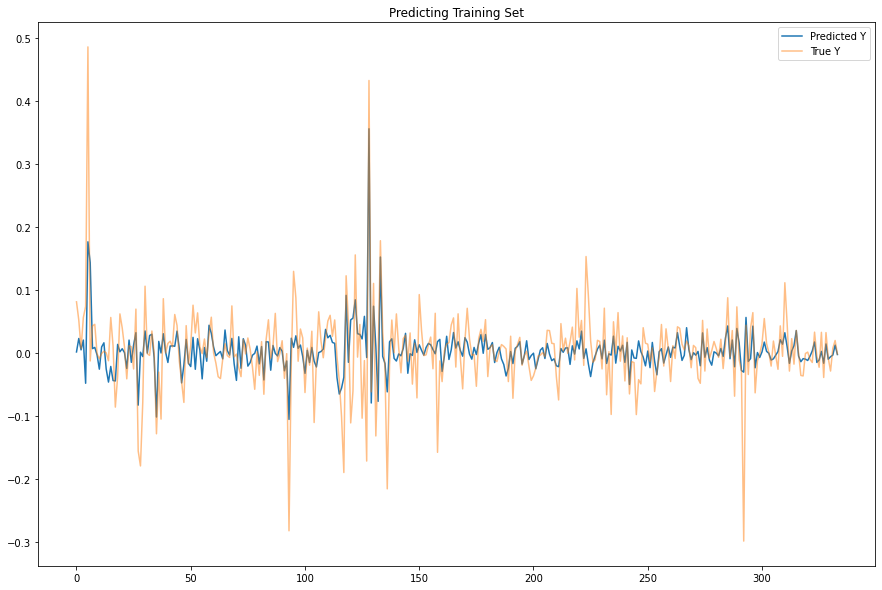

0.2953159097593179


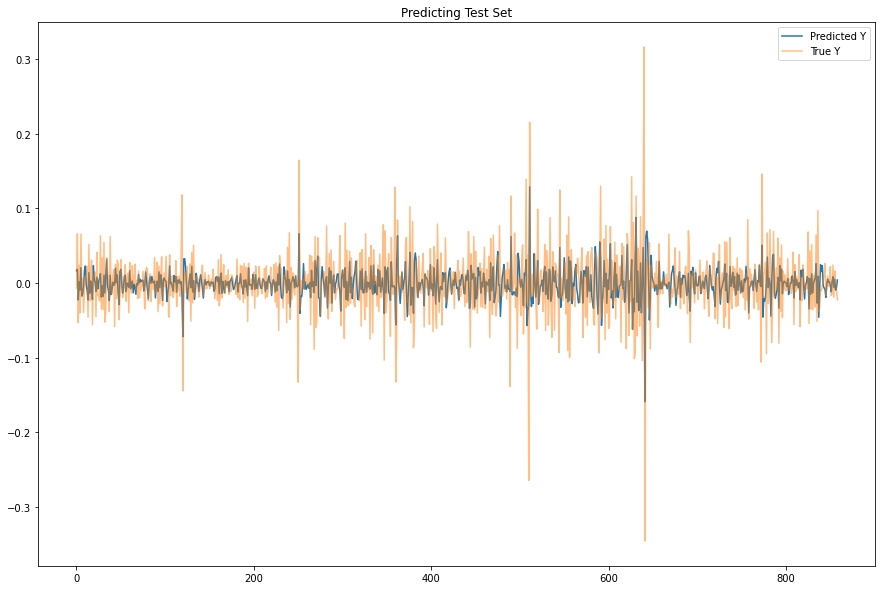

0.33953262836682185


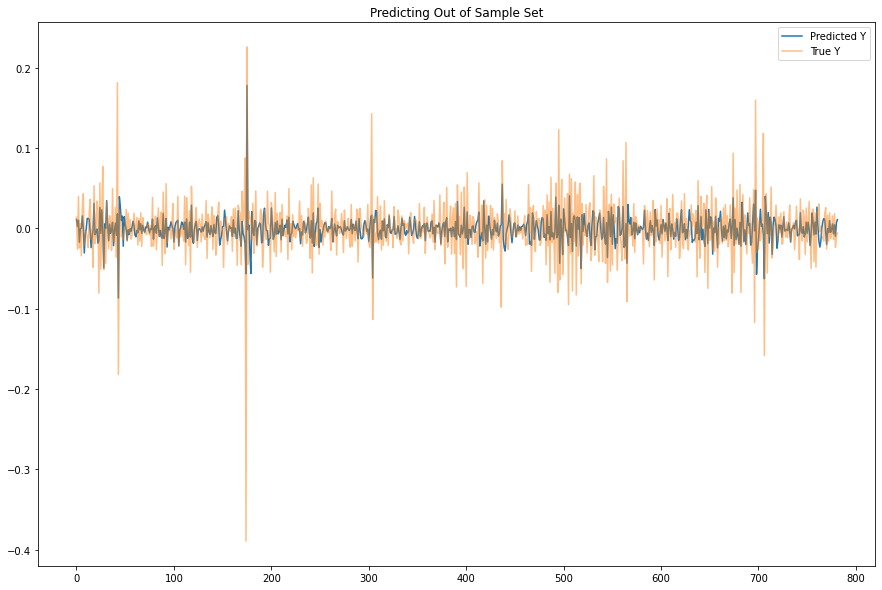

In [6]:
helper = SpreadModelingHelper(sprd, False, unique_sampling=True)

_, frame_size = helper.X_train.shape

mlp_params = {'frame_size': frame_size, 'hidden_size': 8, 'num_outputs': 1, 'loss_fn': "mean_squared_error", 
                    'optmz': "adam", 'metrics': [], 'hidden_layer_activation_function': "sigmoid",
                    'output_layer_act_func': "linear"}

committee = RegressorCommittee(mlp_params, num_committee=10, epochs=500, verbose=False)
committee.fit(helper.X_train, helper.y_train)

train_set, train_pred, test_set, test_pred, oos_set, oos_pred = helper.plot_model_results(committee)

In [7]:
helper.get_metrics(working_df)

,Filtering Method,Annual Returns,Std Dev,Set
0,unfiltered,0.026258,0.065927,train
1,std_threshold,-0.017548,0.097039,train
2,corr_filter,0.030659,0.037317,train
3,std_vol_filter,0.105522,0.098817,train
4,corr_vol_filter,0.037523,0.060044,train
0,unfiltered,-0.164757,0.043861,test
1,std_threshold,-0.030144,0.033621,test
2,corr_filter,-0.144011,0.066007,test
3,std_vol_filter,-0.030783,0.037659,test
4,corr_vol_filter,-0.484160,0.145203,test


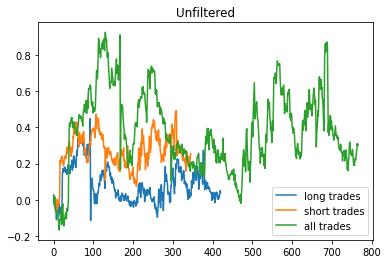

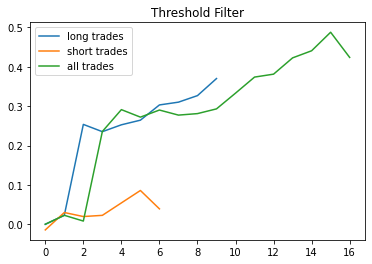

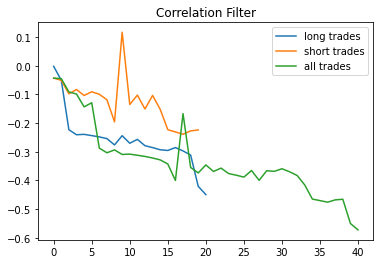

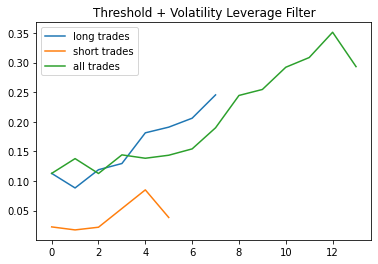

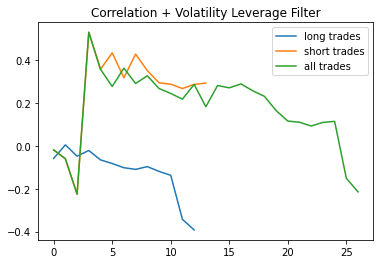

In [8]:
helper.get_filtering_results(oos_set, oos_pred, test_pred, working_df);

# Functional Link Neural Network <a class="anchor" id="flnn"></a>

0.2941717034064898


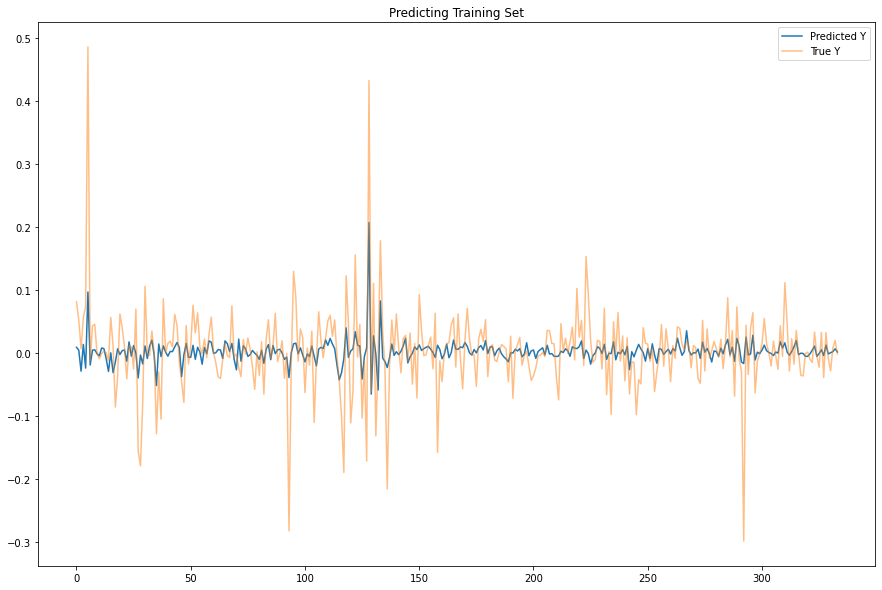

0.19687276339363502


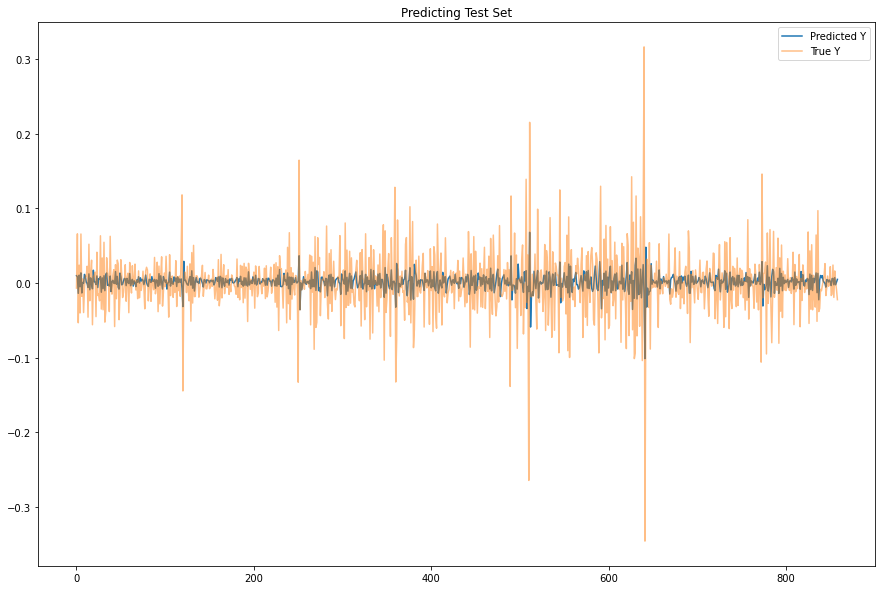

0.222778630788514


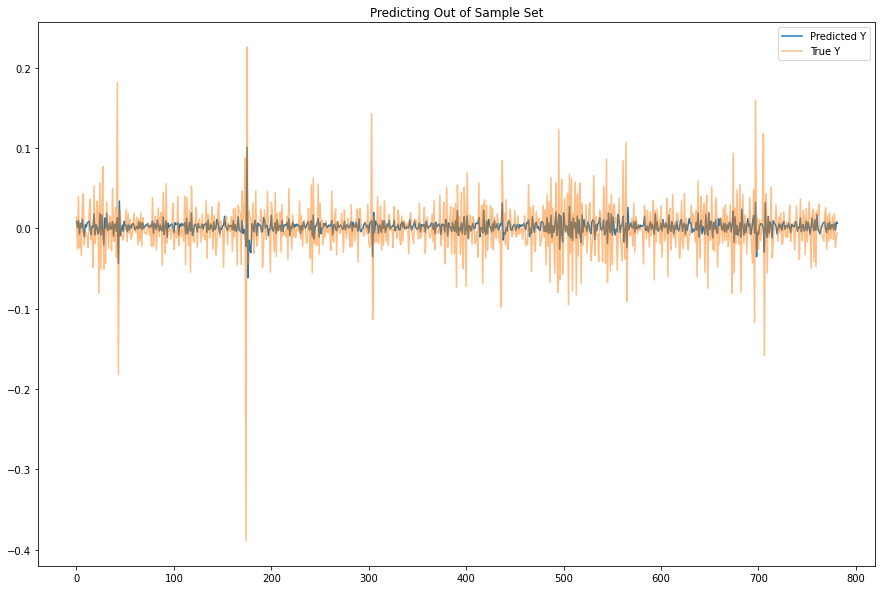

In [9]:
helper = SpreadModelingHelper(sprd, True, unique_sampling=True)

_, frame_size = helper.X_train.shape

honn_params = {'frame_size': frame_size, 'hidden_size': 2, 'num_outputs': 1, 'loss_fn': "mean_squared_error", 
                    'optmz': "adam", 'metrics': [], 'hidden_layer_activation_function': "relu",
                    'output_layer_act_func': "linear"}

committee = RegressorCommittee(honn_params, regressor_class='MultiLayerPerceptron',
                               num_committee=10, epochs=500, verbose=False)
committee.fit(helper.X_train, helper.y_train)

train_set, train_pred, test_set, test_pred, oos_set, oos_pred = helper.plot_model_results(committee)

In [31]:
helper.get_metrics(working_df)

,Filtering Method,Annual Returns,Std Dev,Set
0,unfiltered,0.035534,0.065665,train
1,std_threshold,-0.005690,0.056337,train
2,corr_filter,0.030659,0.037317,train
3,std_vol_filter,0.007431,0.118376,train
4,corr_vol_filter,0.018350,0.036217,train
0,unfiltered,-0.136481,0.043547,test
1,std_threshold,-0.047667,0.033588,test
2,corr_filter,-0.144011,0.066007,test
3,std_vol_filter,-0.060424,0.033376,test
4,corr_vol_filter,-0.068154,0.093524,test


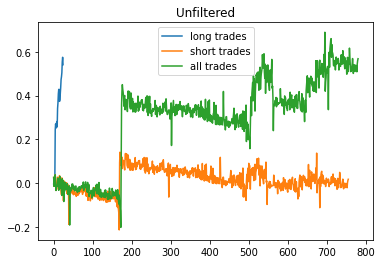

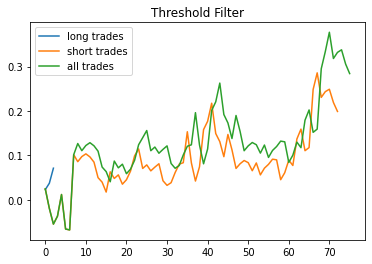

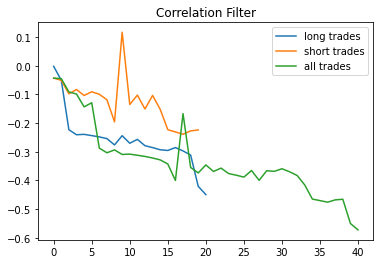

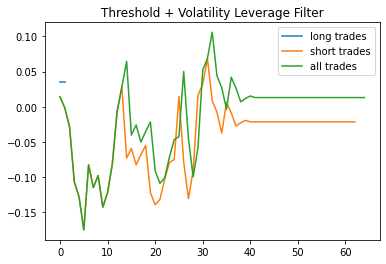

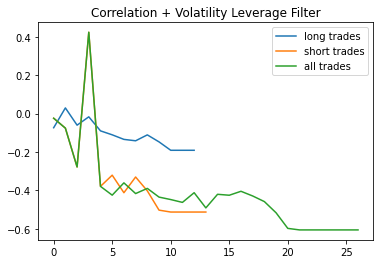

In [32]:
helper.get_filtering_results(oos_set, oos_pred, test_pred, working_df);

# Pi Sigma Neural Network <a class="anchor" id="pisigma"></a>

0.008475540457648978


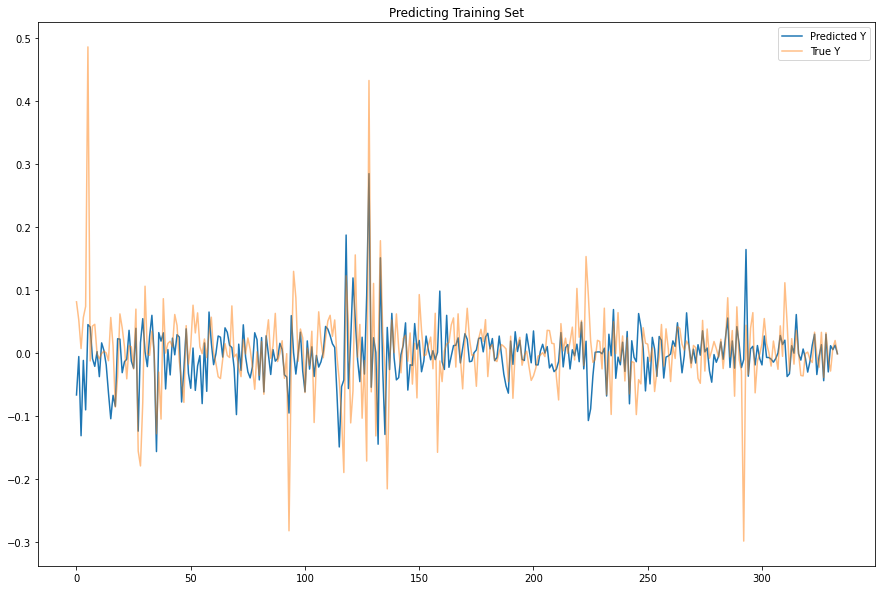

-0.1228866590690274


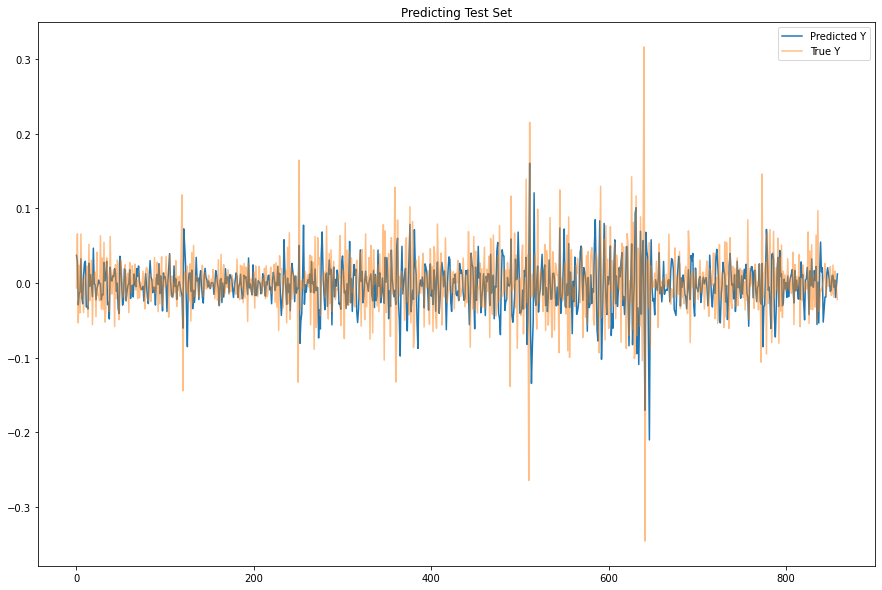

-0.05374418872193454


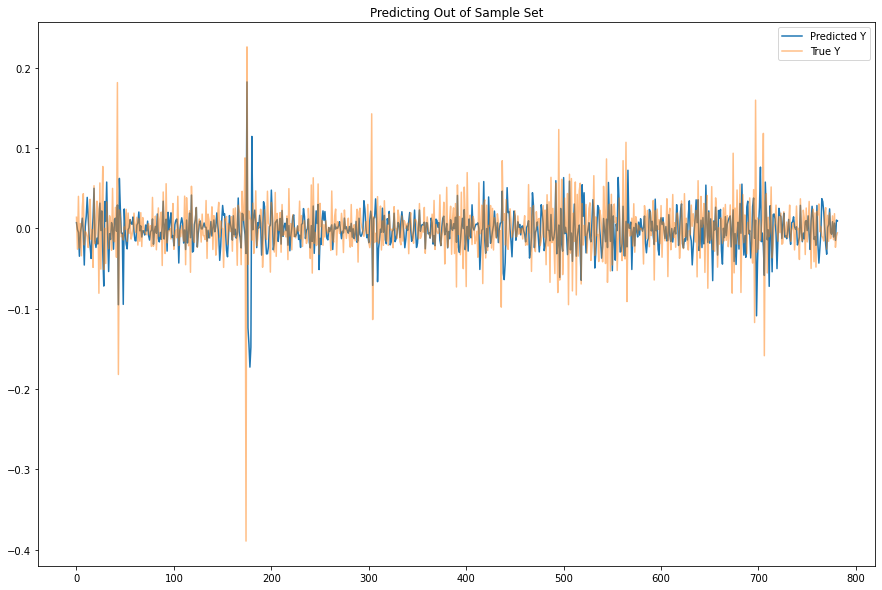

In [118]:
X_train, X_test, X_oos, y_train, y_test, y_oos, ret_scaler = generate_dataset_from_spread(sprd, False, unique_sampling=True)

_, frame_size = X_train.shape

ps_params = {'frame_size': frame_size, 'hidden_size': 6, 'num_outputs': 1, 'loss_fn': "mean_squared_error", 
                    'optmz': "adam", 'metrics': [], 'hidden_layer_activation_function': "linear",
                    'output_layer_act_func': "tanh"}

committee = RegressorCommittee(ps_params, regressor_class='PiSigmaNeuralNetwork',
                               num_committee=10, epochs=500, verbose=False).fit(X_train, y_train)

train_set, train_pred, test_set, test_pred, oos_set, oos_pred = plot_model_results(committee, X_train, X_test, X_oos, y_train, y_test, y_oos, ret_scaler)

In [119]:
get_metrics(train_set, train_pred, test_set, test_pred, oos_set, oos_pred, working_df)

,Filtering Method,Annual Returns,Std Dev,Set
0,unfiltered,0.025029,0.065877,train
1,std_threshold,0.048000,0.175929,train
2,corr_filter,0.030659,0.037317,train
3,std_vol_filter,0.049190,0.246242,train
4,corr_vol_filter,0.027982,0.049416,train
0,unfiltered,-0.197074,0.043469,test
1,std_threshold,-0.048843,0.058508,test
2,corr_filter,-0.144011,0.066007,test
3,std_vol_filter,-0.070120,0.050633,test
4,corr_vol_filter,-0.151221,0.086627,test


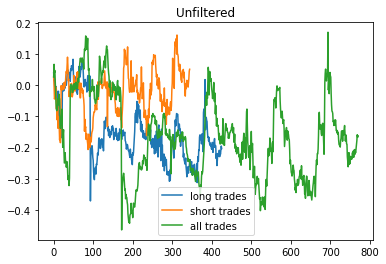

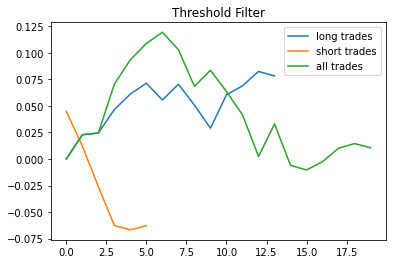

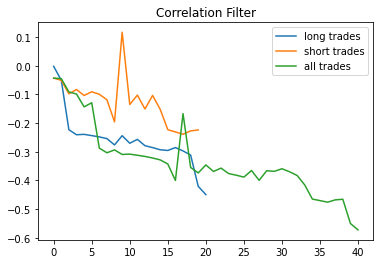

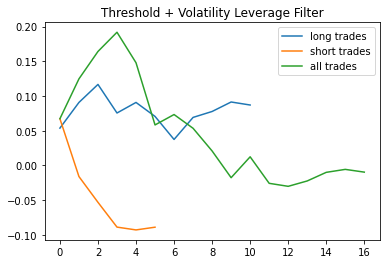

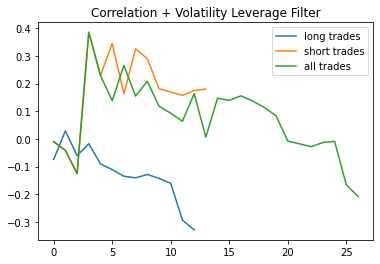

In [120]:
get_filtering_results(oos_set, oos_pred, test_pred, working_df);

# Recurrent Neural Network <a class="anchor" id="rnn"></a>

0.5725508210054115


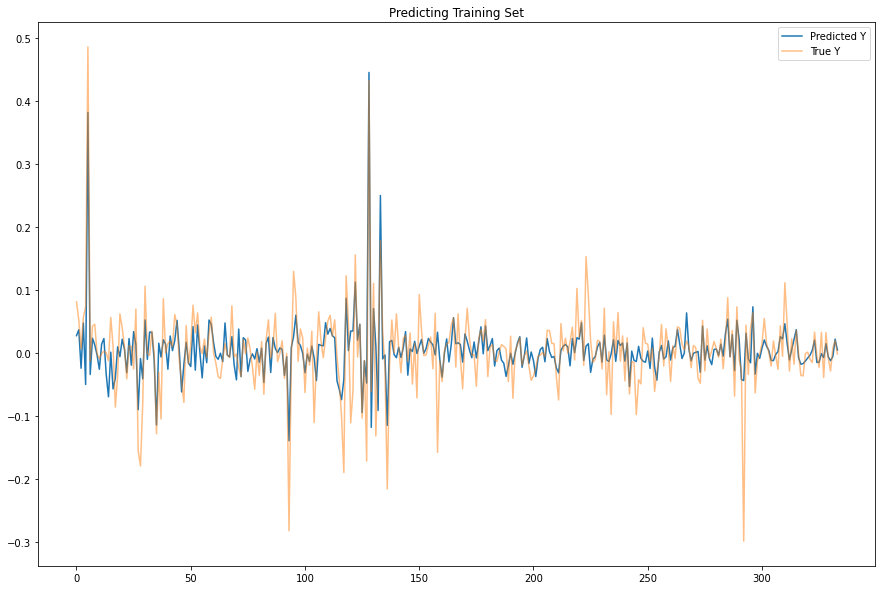

0.38415916971860553


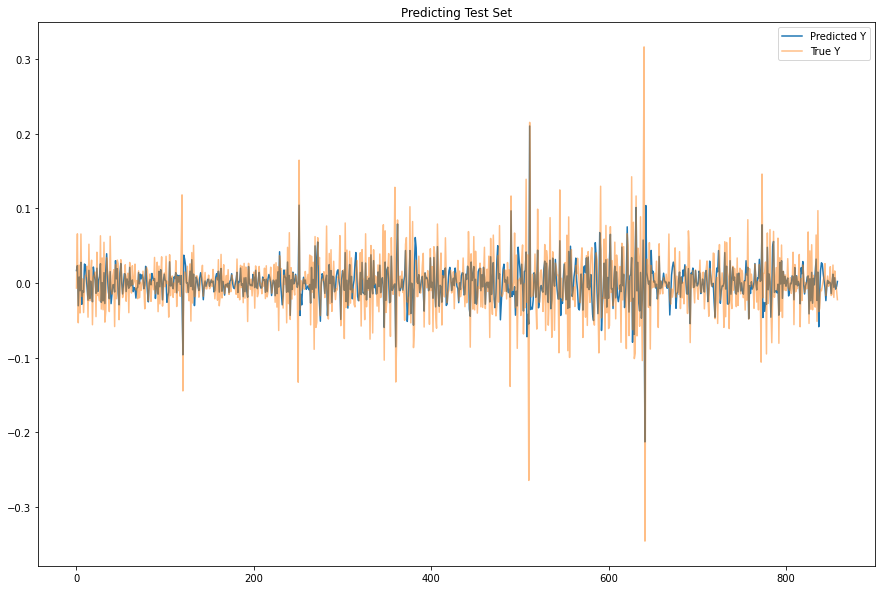

0.4193437025067279


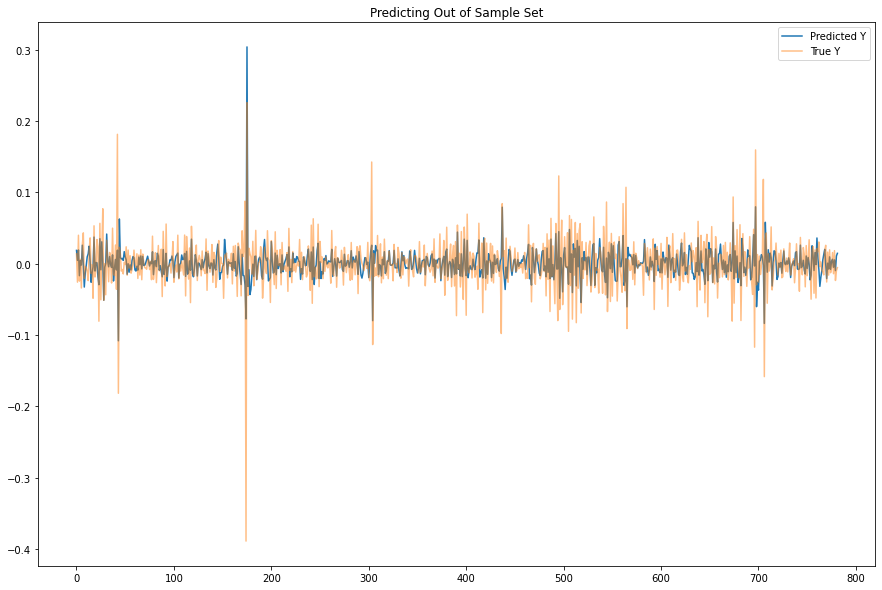

In [121]:
X_train, X_test, X_oos, y_train, y_test, y_oos, ret_scaler = generate_dataset_from_spread(sprd, False, unique_sampling=True)

X_rnn_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_rnn_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_rnn_oos = X_oos.reshape((X_oos.shape[0], X_oos.shape[1], 1))

_, frame_size, no_features = X_rnn_train.shape

rnn_params = {'input_shape': (frame_size, no_features), 'num_outputs': 1, 'loss_fn': "mean_squared_error", 
                    'optmz': "adam", 'metrics': [], 'hidden_layer_activation_function': "relu",
                    'output_layer_act_func': "linear"}

committee = RegressorCommittee(rnn_params, regressor_class='RecurrentNeuralNetwork',
                               num_committee=10, epochs=500, verbose=False).fit(X_rnn_train, y_train)


train_set, train_pred, test_set, test_pred, oos_set, oos_pred = plot_model_results(committee, X_rnn_train,
                                                   X_rnn_test, X_rnn_oos, y_train, y_test, y_oos, ret_scaler)

In [127]:
get_metrics(train_set, train_pred, test_set, test_pred, oos_set, oos_pred, working_df)

,Filtering Method,Annual Returns,Std Dev,Set
0,unfiltered,0.039971,0.066223,train
1,std_threshold,-0.004881,0.048699,train
2,corr_filter,0.030659,0.037317,train
3,std_vol_filter,-0.025091,0.062587,train
4,corr_vol_filter,0.035339,0.049789,train
0,unfiltered,-0.187648,0.043747,test
1,std_threshold,-0.042175,0.031319,test
2,corr_filter,-0.144011,0.066007,test
3,std_vol_filter,-0.022583,0.045543,test
4,corr_vol_filter,-0.499267,0.143601,test


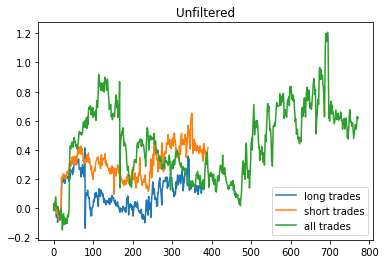

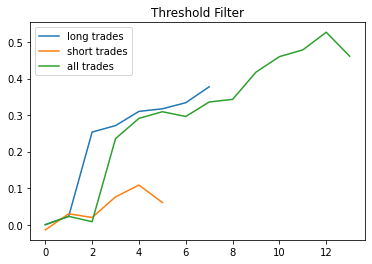

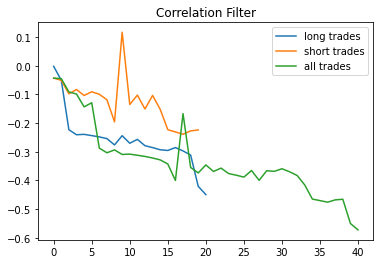

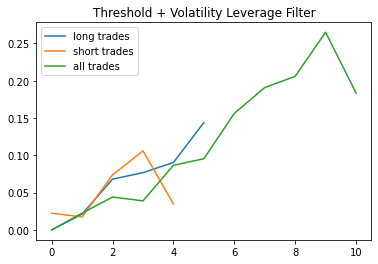

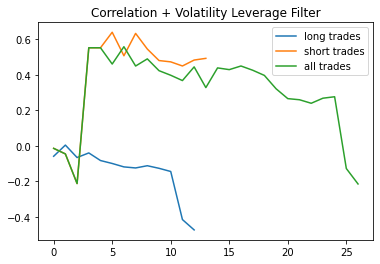

In [123]:
get_filtering_results(oos_set, oos_pred, test_pred, working_df);